<a href="https://colab.research.google.com/github/YoweioY/Product_demand_forecast/blob/master/product_demand_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import statistics
import math

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #連結google drive
data = pd.read_csv('/content/drive/MyDrive/AI_digital/Historical Product Demand.csv')
data

Mounted at /content/drive


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [ ]:
# check the null data
data.isna().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [ ]:
# drop the missing values, we can not fill the date so best way drop missing samples
data.dropna(inplace=True)

# check the null data again
data.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [ ]:
# sort the data according yo date column
data.sort_values('Date', ignore_index=True, inplace=True)
data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011/1/8,2
1,Product_0412,Whse_S,Category_007,2011/10/20,(2)
2,Product_0125,Whse_S,Category_011,2011/10/20,(2)
3,Product_0642,Whse_C,Category_019,2011/10/31,3
4,Product_2137,Whse_S,Category_009,2011/11/18,(25)


In [ ]:
# there are () int the OrderDemand column and we need to remove them
data['Order_Demand'] = data['Order_Demand'].str.replace('(',"")
data['Order_Demand'] = data['Order_Demand'].str.replace(')',"")

# change the dtype as int64
data['Order_Demand'] = data['Order_Demand'].astype('int64')

In [ ]:
# second way change date columns dtype as datetime
from datetime import datetime as dt

# convert the 'Date' column to datetime format
data['Date']= pd.to_datetime(data['Date'])

# create Year, Month, Day columns
data['Year'] = data["Date"].dt.year
data['Month'] = data["Date"].dt.month
data['Day'] = data["Date"].dt.day

In [ ]:
# information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037336 entries, 0 to 1037335
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1037336 non-null  object        
 1   Warehouse         1037336 non-null  object        
 2   Product_Category  1037336 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1037336 non-null  int64         
 5   Year              1037336 non-null  int64         
 6   Month             1037336 non-null  int64         
 7   Day               1037336 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 63.3+ MB


In [ ]:
data.head(10)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day
0,Product_0965,Whse_A,Category_006,2011-01-08,2,2011,1,8
1,Product_0412,Whse_S,Category_007,2011-10-20,2,2011,10,20
2,Product_0125,Whse_S,Category_011,2011-10-20,2,2011,10,20
3,Product_0642,Whse_C,Category_019,2011-10-31,3,2011,10,31
4,Product_2137,Whse_S,Category_009,2011-11-18,25,2011,11,18
5,Product_0288,Whse_S,Category_021,2011-11-18,50,2011,11,18
6,Product_0131,Whse_S,Category_021,2011-11-18,12,2011,11,18
7,Product_2138,Whse_S,Category_009,2011-11-18,49,2011,11,18
8,Product_2143,Whse_S,Category_009,2011-11-18,25,2011,11,18
9,Product_0980,Whse_A,Category_028,2011-11-18,4000,2011,11,18


In [ ]:
# statistical information about OrderDemand
data["Order_Demand"].describe()

count    1.037336e+06
mean     4.949384e+03
std      2.907344e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: Order_Demand, dtype: float64

In [ ]:
# information about categorical variables
data[["Product_Code", "Warehouse", "Product_Category"]].describe()

,Product_Code,Warehouse,Product_Category
count,1037336,1037336,1037336
unique,2160,4,33
top,Product_1359,Whse_J,Category_019
freq,16936,764447,470266


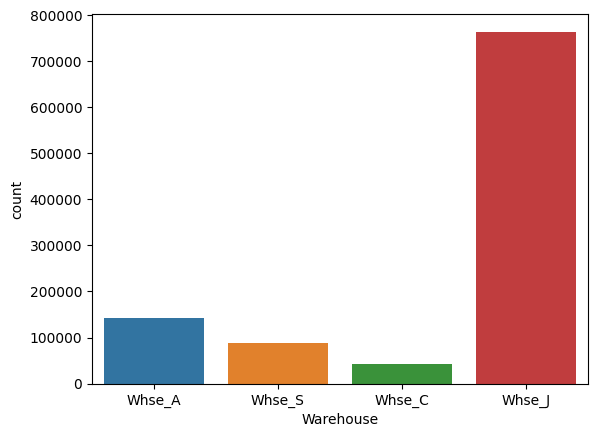

Number of samples according to Warehouse 
Whse_J    764447
Whse_A    142335
Whse_S     88200
Whse_C     42354
Name: Warehouse, dtype: int64


In [ ]:
# Number of samples according to Warehouse
sns.countplot(x="Warehouse", data=data)
plt.xticks(rotation = 0)
plt.show()
print(f"Number of samples according to Warehouse \n{data['Warehouse'].value_counts()}")

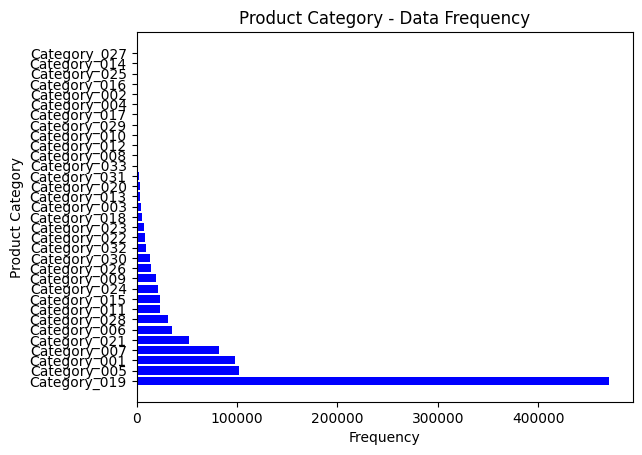

Number of ProductCategory 
Category_019    470266
Category_005    101627
Category_001     97787
Category_007     82402
Category_021     52008
Category_006     35552
Category_028     31012
Category_011     23208
Category_015     22954
Category_024     20885
Category_009     19738
Category_026     14771
Category_030     12997
Category_032      9296
Category_022      8657
Category_023      7899
Category_018      5239
Category_003      4189
Category_013      3743
Category_020      3490
Category_031      2268
Category_033      1849
Category_008      1560
Category_012      1147
Category_010       976
Category_029       671
Category_017       615
Category_004       329
Category_002        77
Category_016        37
Category_025        35
Category_014        26
Category_027        26
Name: Product_Category, dtype: int64


In [ ]:
# Number of samples according to ProductCategory
plt.figure()
plt.barh(data["Product_Category"].value_counts().index, data["Product_Category"].value_counts(), color = "b")
plt.xlabel("Frequency")
plt.ylabel("Product Category")
plt.title("Product Category - Data Frequency")
plt.show()
print(f"Number of ProductCategory \n{data['Product_Category'].value_counts()}")

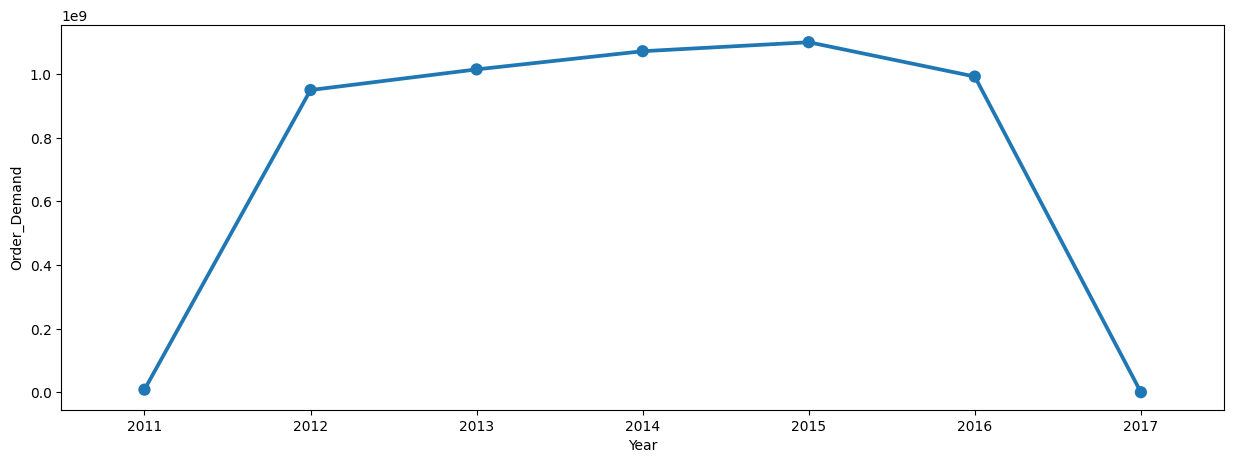

In [ ]:
df = data[['Order_Demand', 'Year']].groupby(["Year"]).sum().reset_index().sort_values(by='Year', ascending=False)
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y='Order_Demand', data=df)
plt.show()

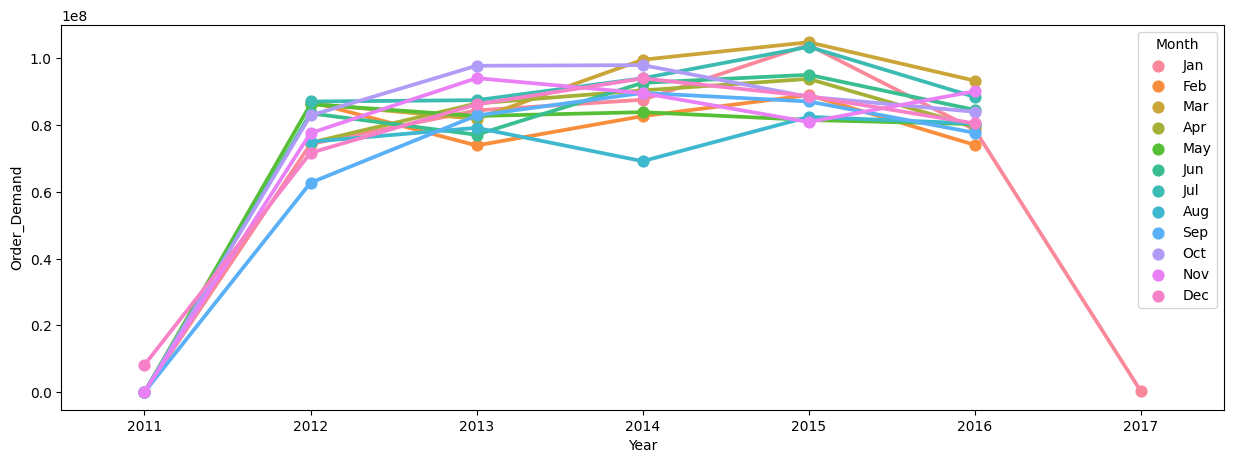

In [ ]:
temp_data = data.copy()
temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df = temp_data[['Order_Demand','Month', 'Year',]].groupby(["Year","Month"]).sum().reset_index().sort_values(by=['Year','Month'], ascending=False)
f, ax = plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y='Order_Demand', data=df, hue='Month', hue_order=['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [ ]:
df = (df.pivot(index='Year', columns='Month', values='Order_Demand'))
df = df.loc[:, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
df

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,2.0,NaN,NaN,NaN,108.0,92000.0,NaN,NaN,6728.0,7.0,86524.0,8178525.0
2012,74331037.0,86951780.0,86463212.0,74714053.0,86246051.0,83521679.0,87071567.0,75003241.0,62748329.0,82891675.0,77618687.0,71698680.0
2013,84399001.0,73899741.0,81857480.0,86489453.0,82735797.0,77115902.0,87469057.0,79181220.0,82882856.0,97773582.0,94072859.0,86210974.0
2014,87593983.0,82688430.0,99580627.0,90391888.0,83876775.0,92655892.0,94023350.0,69199733.0,89629088.0,97963491.0,89572680.0,94002430.0
2015,104028474.0,88991822.0,104825197.0,93842250.0,81540033.0,95074257.0,103449803.0,82468895.0,87080162.0,88477211.0,80944042.0,88676245.0
2016,78627619.0,74065041.0,93303910.0,79503364.0,80299593.0,84553011.0,88439936.0,80471772.0,77698896.0,84000757.0,90128568.0,80497932.0
2017,294967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 檢查月分實際需求量資料筆數
filtered_data = data[(data['Year'] == 2012) & (data['Month'] == 1)]
len(filtered_data)

15614

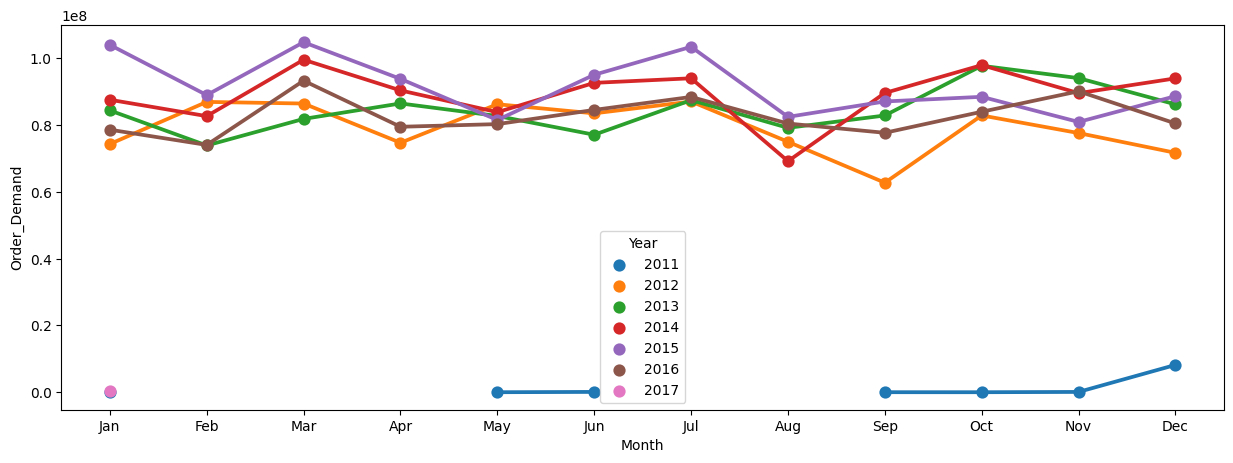

In [ ]:
custom_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5,
               'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}
temp_data = data.copy()
temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df = temp_data[["Order_Demand", 'Month', 'Year']].groupby(["Year","Month"]).sum().reset_index().sort_values(by=['Year','Month'], ascending=True)
df = df.iloc[df['Month'].map(custom_dict).argsort()]
f, ax = plt.subplots(figsize=(15, 5))
sns.pointplot(x='Month', y="Order_Demand", data=df, hue="Year")
plt.show()

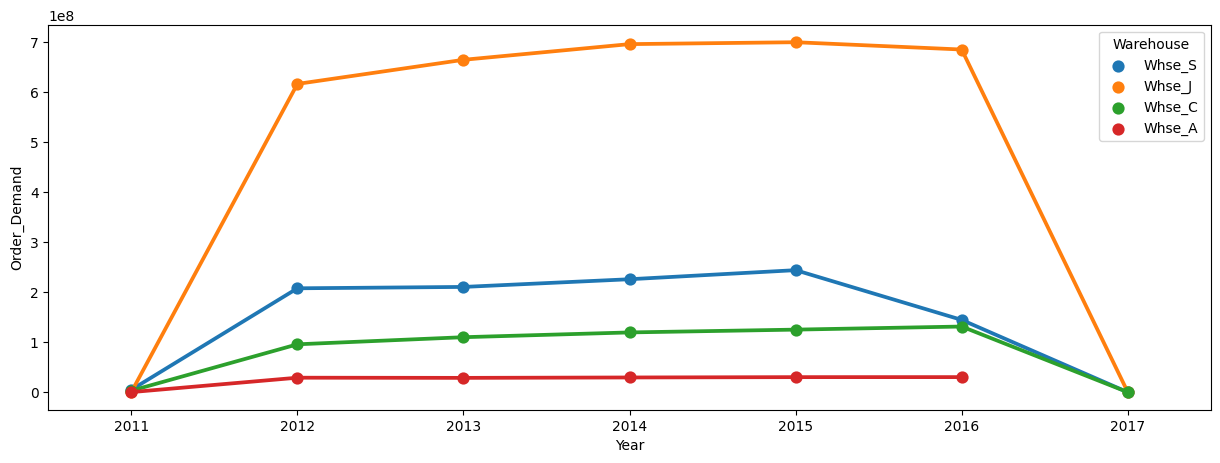

In [ ]:
# Warehouse Based Analysis
df = data[["Order_Demand", 'Year', 'Warehouse']].groupby(["Year","Warehouse"]).sum().reset_index().sort_values(by=['Warehouse','Year'], ascending=False)
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y="Order_Demand", data=df, hue="Warehouse")
plt.show()

In [ ]:
df = (df.pivot(index='Year', columns='Warehouse', values='Order_Demand'))
df

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
Year,,,,
2011,230881.0,3031847.0,198547.0,4902619.0
2012,29048000.0,95823181.0,616560449.0,207828361.0
2013,28696890.0,110035879.0,664781670.0,210573483.0
2014,29507380.0,119583036.0,696130811.0,225957140.0
2015,30167990.0,125188986.0,699932604.0,244108811.0
2016,30226290.0,131373097.0,685336996.0,144654016.0
2017,NaN,35378.0,259319.0,270.0


In [ ]:
# Product Category Based Analysis
df = data[["Order_Demand",'Product_Category', 'Warehouse']].groupby(["Product_Category","Warehouse"]).sum().reset_index().sort_values(by=['Order_Demand'],ascending=False)
df = df.pivot(index='Product_Category', columns='Warehouse', values='Order_Demand')
df

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
Product_Category,,,,
Category_001,1749.0,60106.0,1.623054e+06,72564.0
Category_002,NaN,NaN,NaN,628.0
Category_003,131607.0,NaN,3.926700e+04,222076.0
Category_004,NaN,NaN,NaN,99046.0
Category_005,1124300.0,12528700.0,1.289245e+08,57097050.0
Category_006,11613427.0,33131500.0,3.187667e+08,42059693.0
Category_007,2839680.0,7179524.0,1.121572e+08,6515085.0
Category_008,1903.0,317.0,1.534800e+04,NaN
Category_009,920903.0,251031.0,4.464690e+05,2163738.0


In [ ]:
df = data[["Order_Demand",'Product_Category', 'Year']].groupby(["Product_Category","Year"]).sum().reset_index().sort_values(by=['Order_Demand'],ascending=False)
df = df.pivot(index='Product_Category', columns='Year', values='Order_Demand')
df

Year,2011,2012,2013,2014,2015,2016,2017
Product_Category,,,,,,,
Category_001,997.0,275607.0,320250.0,369620.0,389403.0,401567.0,29.0
Category_002,NaN,NaN,201.0,204.0,223.0,NaN,NaN
Category_003,1708.0,75056.0,92937.0,82232.0,94320.0,46697.0,NaN
Category_004,2780.0,23810.0,26401.0,25176.0,20879.0,NaN,NaN
Category_005,673750.0,35198945.0,36201555.0,43707445.0,45454520.0,38427705.0,10600.0
Category_006,490509.0,67259055.0,81419576.0,81544531.0,92122245.0,82665414.0,70000.0
Category_007,28564.0,24717088.0,28037572.0,27132962.0,25740371.0,23032502.0,2472.0
Category_008,NaN,3680.0,2826.0,3544.0,4341.0,3177.0,NaN
Category_009,1577.0,747277.0,840534.0,825505.0,903441.0,463807.0,NaN


In [ ]:
# for better results use the data between 2012-01-01 and 2016-12-31
df = data[(data['Date']>='2012-01-01') & (data['Date']<='2016-12-31')].sort_values('Date', ascending=True)
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
df

,Date,Order_Demand
0,2012-01-01,2
1,2012-01-02,680277
2,2012-01-03,1645257
3,2012-01-04,1295861
4,2012-01-05,8941774
...,...,...
1676,2016-12-26,3628370
1677,2016-12-27,1674226
1678,2016-12-28,2740302
1679,2016-12-29,530487


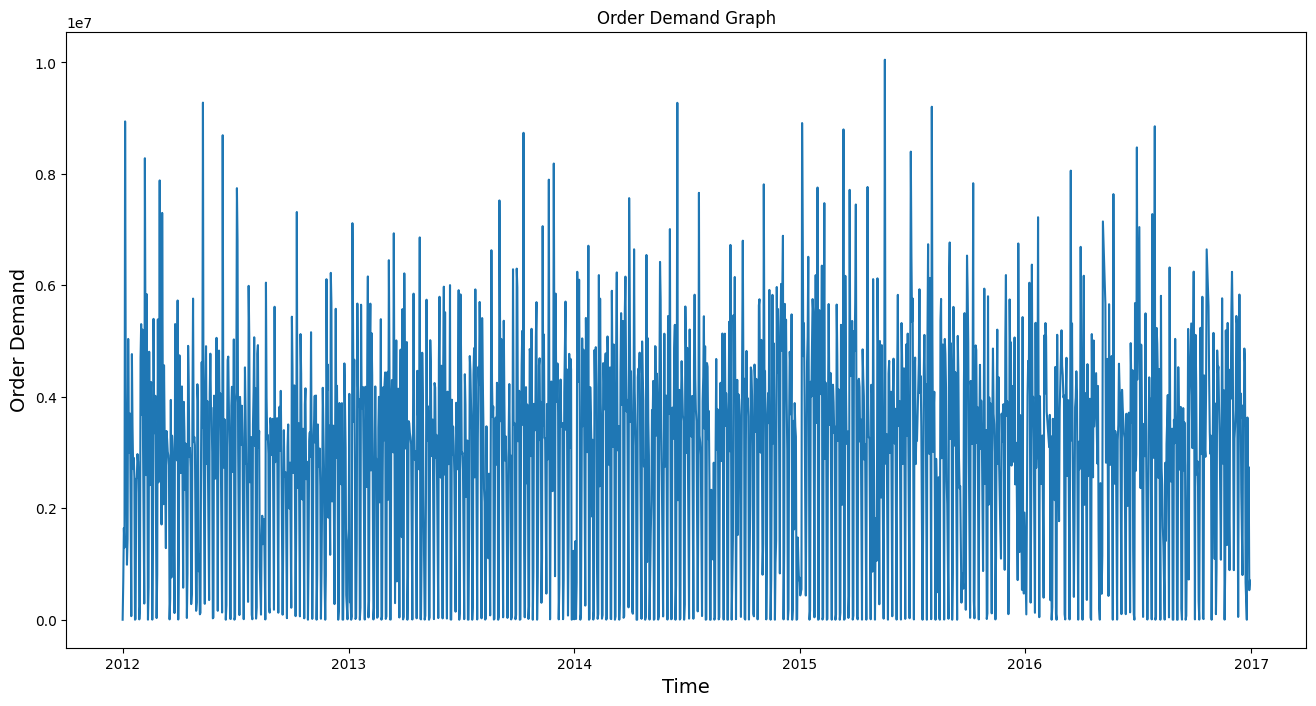

In [ ]:
# Visualize the order demand as time series
plt.figure(figsize=(16, 8))
plt.title("Order Demand Graph")
plt.plot(df["Date"], df["Order_Demand"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("Order Demand", fontsize=14)
plt.show()

In [ ]:
# 只保留需求量欄位
orderD = df.filter(["Order_Demand"])

from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

# 创建标准化器
scaler = MinMaxScaler()
# scaler = StandardScaler()

# 将训练数据进行标准化
df_scaled = pd.DataFrame(scaler.fit_transform(orderD))

# 分割數字
length = math.ceil(len(orderD) * 0.8)
orderD.max()

Order_Demand    10048663
dtype: int64

In [ ]:
# 取後面0.2的資料作為測試集，前面0.8為訓練集
df_train = df_scaled.iloc[:length,:]
df_test = df_scaled.iloc[length-90:,:]

In [ ]:
# 每個時段長(ex:前30個時間點數值)作為訓練單位，預測下一個時間點的數值(ex:第31個時間點數值)。
def tm_series(z,period):
    window = len(z.index)-period
    timedata = []
    for i in range(window):
        timedata.append([])
        for k in range(period):
            timedata[i].append(z.iloc[i+k,0])
    train = np.float64(timedata)
    return train

In [ ]:
# train_x 每六個時間點作為訓練單位，總資料筆數為(1880-6)，欄位為6個時間點*6個點位(36)
train_x_90 = tm_series(df_train,90)
train_x_90.shape

(1255, 90)

In [ ]:
# train_y 從第31時間點往後取
train_y_90 = np.float64(df_train.iloc[90:,0])
train_y_90.shape

(1255,)

In [ ]:
# test_x 測試集後面的資料筆數，欄位為30個時間點*1(30)
test_x_90 = tm_series(df_test,90)
test_x_90.shape

(336, 90)

In [ ]:
# test_y 從測試集的第31時間點往後取
test_y_90 = np.float64(df_test.iloc[90:,0])
test_y_90.shape

(336,)

In [ ]:
import xgboost as xgb
from sklearn import metrics
from matplotlib.pyplot import MultipleLocator # 畫圖用
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV # randomgridsearch 調參

In [ ]:
# 建立XGBoost模型
def xgb_model(train_x,train_y,test_x,test_y):
    xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',verbosity=1)
    # 設定樹深度、學習率、樹數量等參數範圍
    hyperparameter_space = {'max_depth':[2,3,4,5,6,7,8,9,10,11,12],
                        'min_child_weight':[0.5, 1, 2, 3, 4, 5, 6],
                        'learning_rate':[0.01, 0.05 , 0.1, 0.5],
                        'n_estimators': [300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
                        'subsample': [0.6, 0.7, 0.8, 2],
                        'colsample_bytree': [0.3, 0.5, 0.7, 2],
                            }
    # 隨機選取30種參數組合
    rs = RandomizedSearchCV(xgb_model, hyperparameter_space, n_iter=30, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=1)
    rs.fit(train_x,train_y)
    rs.best_estimator_.fit(train_x,train_y) #選擇最優良的參數組合
    y_pred = rs.best_estimator_.predict(test_x)
    MAE = np.round(metrics.mean_absolute_error(test_y, y_pred), 3)
    MSE = np.round(metrics.mean_squared_error(test_y, y_pred), 3)
    score = rs.best_estimator_.score(test_x, test_y)
    best_params = rs.best_params_

    return MAE, MSE, y_pred, best_params, score

In [ ]:
MAE, MSE, y_pred, bp, score = xgb_model(train_x_90,train_y_90,test_x_90,test_y_90)

In [ ]:
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))
y_pred.shape

(336, 1)

In [ ]:
MAE,MSE

(0.136, 0.032)

In [ ]:
bp

{'subsample': 0.8,
 'n_estimators': 900,
 'min_child_weight': 6,
 'max_depth': 8,
 'learning_rate': 0.05,
 'colsample_bytree': 0.7}

In [ ]:
score

0.09797158114472826

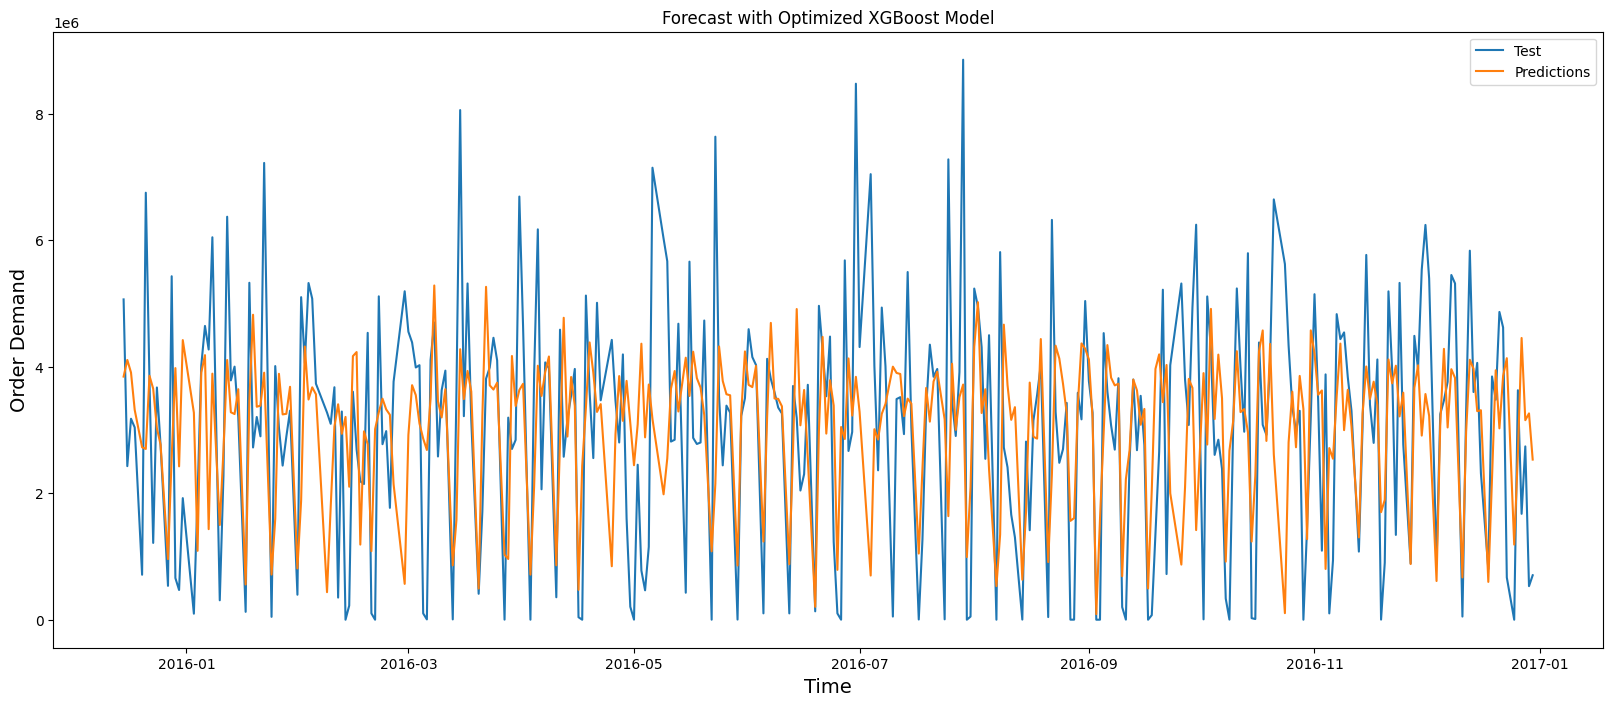

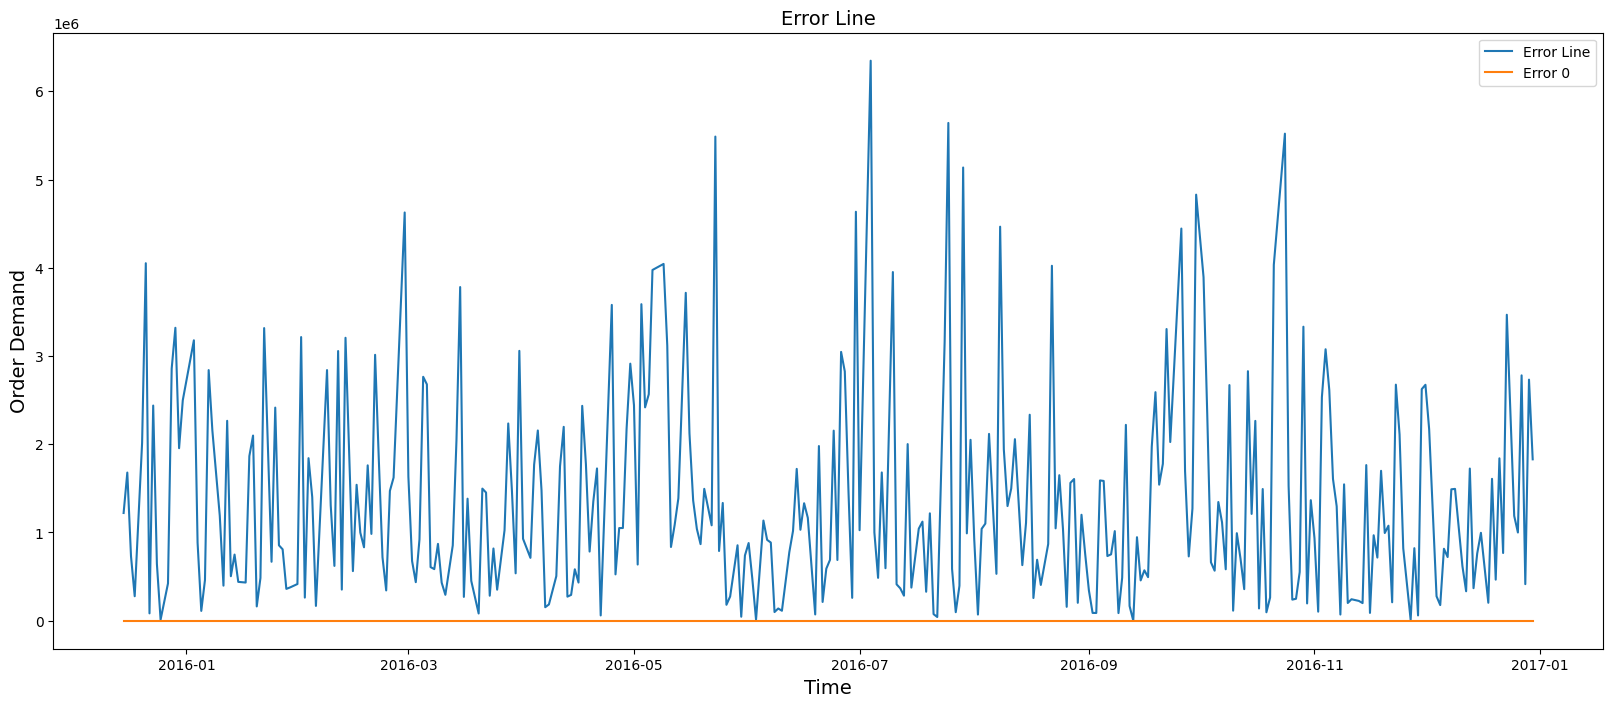

In [ ]:
# 將原本標準化的數值轉回原數值
o_predictions = scaler.inverse_transform(y_pred)
train = orderD[:length]
test = orderD[length:]
test["Predictions"] = o_predictions
# 畫模型預測數值與實際數值變化圖

plt.figure(figsize=(20, 8))
plt.title("Forecast with Optimized XGBoost Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
# plt.plot(df["Date"][:train_close_len], train["Order_Demand"])
plt.plot(df["Date"][length:], test[["Order_Demand", "Predictions"]])
plt.legend(["Test", "Predictions"], loc="upper right")
plt.show()

# 畫誤差變化圖
plt.figure(figsize=(20,8))
plt.title("Error Line", fontsize=14)
plt.plot(df["Date"][length:],abs(test-o_predictions))
# plt.ylim(-10,250)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.legend(["Error Line", "Error 0"], loc="upper right")
plt.show()

In [ ]:
sumse = 0

test_scaled = pd.DataFrame(scaler.fit_transform(test))

for i in range(len(test_scaled)):
    sumse += (test_scaled.iloc[i,0] - 0.3035)**2
    print(test_scaled.iloc[i,0])
sumse

16.130065547899605

In [ ]:
df_merged = pd.concat([test,df["Date"][length:]], axis=1)

In [ ]:
df_merged

,Order_Demand,Predictions,Date
1345,5064710,3844016.50,2015-12-15
1346,2428339,4107324.50,2015-12-16
1347,3177822,3908483.50,2015-12-17
1348,3040342,3317815.25,2015-12-18
1349,711247,2726067.00,2015-12-20
...,...,...,...
1676,3628370,2628525.25,2016-12-26
1677,1674226,4454644.00,2016-12-27
1678,2740302,3154868.75,2016-12-28
1679,530487,3262414.00,2016-12-29


In [ ]:
df_merged.to_csv('/content/drive/MyDrive/AI_digital/第四組報告/祐瑋/testdata.csv', index=False)

In [ ]:
# 產品固定19、倉庫看有沒有需要固定
# 有沒有需要預測時間間隔
# epoch大小
# learning rate大小
# 調整神經數與層數方法
# 存模型、設停損點
# mae、mse、mape
# 不要加起來直接丟
# outlier